# Statistical analysis of published research paper: 

Full scholarly article found on github here: [Effects of acupuncture with needle manipulation at different frequencies for patients with hypertension: Result of a 24- week clinical observation](https://github.com/papir805/acupuncture_scholarly_analysis/blob/master/acupuncture_scholarly_article.pdf)

**Abstract**

Objectives: To investigate whether the manipulation parameter of the twirling frequency in acupuncture affects the blood pressure when acupuncture is applied on the acupoints ST9 and LR3 in a human body.

Design: A randomized, controlled trial.

Interventions: A hundred and twenty patients with hypertension were randomized into four treatment groups. A twirling frequency of 120 twirls per minute or 60 twirls per minute were respectively applied on the acupoints ST9 or LR3. Each patient received five acupuncture sessions a week over a period of 12 weeks, with a follow-up period of a further12 weeks. The outcome was assessed by using an ambulatory blood pressure monitor.

Results: A hundred and twenty twirls per minute on ST9 could overall improve the BP (24hDBP, mSBP, mDBP, dDBP, nSBP and nDBP). Sixty twirls per minute on ST9 improved the 24hDBP, dSBP, dDBP and mDBP; 120 twirls per minute on LR3 did not show any anti-hypertensive effect, while 60 twirls per minute on LR3 improved the dSBP and dDBP. The results indicated that the acupuncture effect on BP, the onset of anti-hypertensive effect, the occurrence of the effect, and the duration of the effect depended on the frequency of needle manipulation on the same acupuncture point.

Conclusions: As one of the important factors of the effects of acupuncture, the manipulation parameter's impact has its specificity for different acupoints. Thus, in the future, close attention needs to be paid to this clinically.

In [1]:
import math
import pandas as pd
import numpy as np
import scipy.stats as st
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2, f, t
from statsmodels.stats.proportion import proportions_ztest, proportions_chisquare
from statsmodels.formula.api import ols
from IPython.display import Markdown as md
%matplotlib inline

In [2]:
orig_df = pd.read_csv("./data/Acupuncture Data.csv")

In [3]:
orig_df.shape

(120, 53)

## Why do we care?

According to the scholarly article, hypertension affects one-third of young adults, two-thirds of people over the age of 60, three-quarters of people over the age of 70, and is a leading contributer to many of the leading causes of death worldwide.  If one was able to reduce blood pressure with acupuncture, it could have serious cost savings for the healthcare system and could lead to longer lives for many people worldwide.

### Q1: Is there a significant difference in the proportion of high 24-hour Systolic Blood Pressure (SBP) at 24 weeks of acupucuncture treatment for individuals below the age of 60 or those who are 60+?

To answer the question, we have to create a new variable that bins ages based on our critera of below age 60, or age 60+.

In [4]:
age_bins = [0, 60, 100]
age_labels = ['below_60', '60_or_above']

orig_df['binned_ages'] = pd.cut(orig_df['age'], bins=age_bins, right=False, labels=age_labels)

We'll define high SBP as 130+ mmHg and create a new variable that bins accordingly.

In [5]:
n24hsbp6_bins = [0, 130, 200]
n24hsbp6_labels = ['below_130', '130_or_above']

orig_df['binned_24hsbp6'] = pd.cut(orig_df['n24hsbp6'], bins=n24hsbp6_bins, right=False, labels=n24hsbp6_labels)

### Q1.a: Because we have sample sizes larger than 30, we'll use a z-test for two population proportions to answer our question.

#### *Step 1: Hypotheses*

<ins>In words</ins><br>
$H_0:$ There is no difference in the proportion of high 24-hour SBP values (130+ mmHg) at 24 weeks between individuals less than 60 years of age and greater than or equal to 60 years.  <br>
$H_a:$ There is a difference in the proportion of high 24-hour SBP values (130+ mmHg) at 24 weeks between individuals less than 60 years and greater than or equal to 60 years. <br>

<ins>Using symbols</ins><br>
$H_0: p_1 = p_2$ <br>
$H_a: p_1 \neq p_2$

#### *Step 2: Critical value(s)*

Reject the null hypothesis ($H_0$) if the calculated test statistic is less than or equal to -1.96, or greater than or equal to 1.96, based on a two-tailed test using the Normal (Z) Distribution, using $\alpha = 0.05$.

e.g. $Z_{\alpha/2} \leq -1.96 \text{   or   } Z_{1 - \alpha/2} \geq 1.96$

In [6]:
alpha = 0.05
z_crit_left = norm.ppf(alpha/2)
z_crit_right = norm.ppf(1 - alpha/2)
print(F"Z_critical_left: {z_crit_left:.2f}")
print(F"Z_critical_right: {z_crit_right:.2f}")

Z_critical_left: -1.96
Z_critical_right: 1.96


#### *Step 3: Calculate Test Statistic*

In [7]:
# Create a cross tabulation based on our binning to use in our hypothesis test
observed_freq_by_age_with_totals = pd.crosstab(orig_df['binned_ages'], orig_df['binned_24hsbp6'], margins=True, margins_name='Total')
observed_freq_by_age_with_totals

binned_24hsbp6,below_130,130_or_above,Total
binned_ages,,,
below_60,17,15,32
60_or_above,17,16,33
Total,34,31,65


Calculate test statistic using statsmodels library based on the following formula:
    
$Z = \frac{\hat{p}_1 - \hat{p}_2 - (p_1 - p_2)}{\sqrt{\frac{\bar{p}(1-\bar{p})}{n_1}+\frac{\bar{p}(1-\bar{p})}{n_2}}}$

where $\bar{p} = \frac{x_1 + x_2}{n_1 + n_2}$

In [8]:
# Grab counts from our cross tab
x_counts = observed_freq_by_age_with_totals.iloc[:, 1][0:2].values
n_counts = observed_freq_by_age_with_totals.iloc[:, 2][0:2].values

z_test_stat, p_val = proportions_ztest(x_counts, n_counts, value=0)

true_or_false = abs(z_test_stat) >= abs(z_crit_left)

print(F"Z test stat: {z_test_stat:.2f}")
print(F"P-value: {p_val:.4f}")
print(F"Test statistic in rejection region?: {true_or_false}")

Z test stat: -0.13
P-value: 0.8966
Test statistic in rejection region?: False


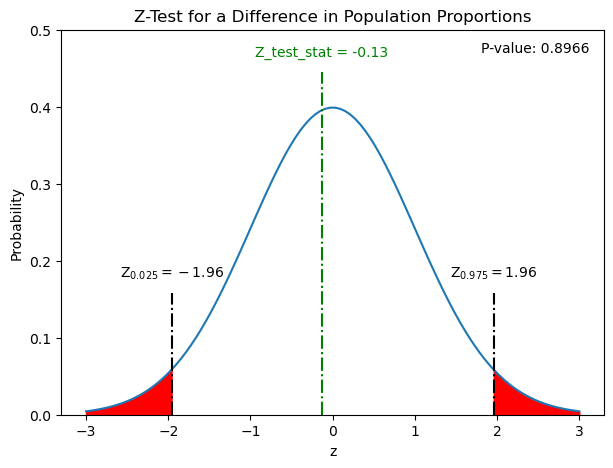

In [9]:
mu = 0
variance = 1
sigma = math.sqrt(variance)

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_rejection_left = np.linspace(mu - 3*sigma, z_crit_left, 100)
x_rejection_right = np.linspace(z_crit_right, mu + 3*sigma, 100)

Y_left = st.norm.pdf(x_rejection_left, mu, sigma)
Y_right = st.norm.pdf(x_rejection_right, mu, sigma)


plt.plot(x, st.norm.pdf(x, mu, sigma))
plt.vlines(x=z_test_stat, ymin=0, ymax=st.norm.pdf(z_test_stat)+.05, color='green', linestyle='-.')
plt.vlines(x=z_crit_left, ymin=0, ymax=Y_left.max()+.1, color='black', linestyle='-.')
plt.vlines(x=z_crit_right, ymin=0, ymax=Y_right.max()+.1, color='black', linestyle='-.')
plt.fill_between(x_rejection_left, Y_left, 0, color='red')
plt.fill_between(x_rejection_right, Y_right, 0, color='red')

text = f'Z_test_stat = {z_test_stat:.2f}'

plt.annotate(text, 
             xy=(z_test_stat, st.norm.pdf(z_test_stat)+0.07), 
             ha='center',
             color='green')


z_crit_left_rounded = np.round(z_crit_left, 2)
text = f'Z$_{{{alpha/2}}}= {z_crit_left_rounded}$'

plt.annotate(text, 
             xy=(z_crit_left, st.norm.pdf(z_crit_left)+0.12), 
             ha='center')

z_crit_right_rounded = np.round(z_crit_right, 2)
text = f'Z$_{{{1-alpha/2}}}= {z_crit_right_rounded}$'

plt.annotate(text, 
             xy=(z_crit_right, st.norm.pdf(z_crit_right)+0.12), 
             ha='center')

plt.annotate(f'P-value: {p_val:.4f}', xy=(1.8, 0.47), ha='left')

plt.ylim(0, 0.5)
plt.xlabel('z')
plt.ylabel('Probability')
plt.title('Z-Test for a Difference in Population Proportions')

fig = plt.gcf()
fig.set_size_inches(7,5)

plt.savefig('/users/rancher/Google Drive/Coding/website/github_pages/images/acupuncture_analysis/z_dist_graph1.png')

In [12]:
Y_left

array([0.00443185, 0.0045735 , 0.00471915, 0.0048689 , 0.00502286,
       0.00518111, 0.00534375, 0.00551089, 0.00568264, 0.00585908,
       0.00604034, 0.00622653, 0.00641774, 0.00661409, 0.0068157 ,
       0.00702268, 0.00723514, 0.00745321, 0.00767701, 0.00790665,
       0.00814227, 0.00838398, 0.00863191, 0.0088862 , 0.00914696,
       0.00941434, 0.00968847, 0.00996947, 0.0102575 , 0.01055268,
       0.01085516, 0.01116507, 0.01148257, 0.01180779, 0.01214089,
       0.012482  , 0.01283128, 0.01318888, 0.01355494, 0.01392964,
       0.0143131 , 0.01470551, 0.015107  , 0.01551774, 0.01593789,
       0.01636761, 0.01680706, 0.01725641, 0.01771581, 0.01818543,
       0.01866545, 0.01915602, 0.01965732, 0.0201695 , 0.02069275,
       0.02122723, 0.02177312, 0.02233057, 0.02289977, 0.02348089,
       0.0240741 , 0.02467957, 0.02529748, 0.02592799, 0.02657129,
       0.02722755, 0.02789693, 0.02857961, 0.02927577, 0.02998558,
       0.03070921, 0.03144683, 0.03219862, 0.03296473, 0.03374

#### *Step 4: Conclusion - Using statistical language*

Fail to reject $H_0$ because the calculated test statistic is not in the rejection region.  We don't have statistically significant evidence that there is a difference in the proportion of high 24-hour SBP values (130+ mmHg) at 24 weeks between individuals less than 60 years and greater than or equal to 60 years, at $\alpha=0.05$.

#### Conclusion - Using plain English

It appears that the proportion of those below age 60 with high systolic blood pressure is the same as it is for those age 60+.  This is interesting because the scholarly article says that 2/3 of those above age 60 have hypertension, yet in our sample we're only seeing roughly 1/2 having hypertension in each of the two age groups.

Keep in mind that there are two types of hypertension, systolic hypertension and diastolic hypertension, and I would assume that 2/3 proportion stated in the scholarly article are for both types of hypertension combined, however it's unclear.  Given that this hypothesis test focused solely on systolic blood pressure, that could be part of the discrepancy.

Furthermore, we're looking at results after 24 weeks of the acupuncture treatment, so while we might expect to see a higher proportion of those age 60+ with hypertension, perhaps the acupuncture treatments have been more effective on the older patients in this study.

### Q1.b: Alternatively, we could use a Chi-Square ($\chi^2$) test to test the same hypothesis as in Q1a., which is as follows:

#### *Step 1: Hypotheses*
<ins>In words</ins><br>
$H_0:$ There is no difference in the proportion of high 24-hour SBP values (130+ mmHg) at 24 weeks between individuals less than 60 years and greater than or equal to 60 years.  <br>
$H_a:$ There is a difference in the proportion of high 24-hour SBP values (130+ mmHg) at 24 weeks between individuals less 60 years than and greater than or equal to 60 years. <br>

<ins>Using symbols</ins><br>
$H_0: p_1 = p_2$ <br>
$H_a: p_1 \neq p_2$

#### *Step 2: Critical value(s)*

Reject the null hypothesis ($H_0$) if the calculated test statistic is greater than or equal to 3.841, based on a right-tailed test using the Chi-Square ($\chi^2$) Distribution, using $\alpha = 0.05$.

e.g. $\chi^2_{1-\alpha/2, df} \geq 3.841$

where $df = (r - 1) * (c - 1)$

In [1313]:
# Because the cross tab contains a row and column for totals, we need to subtract one from each of the tables dimensions to get an accurate num_rows and num_cols
num_rows = observed_freq_by_age_with_totals.shape[0] - 1
num_cols = observed_freq_by_age_with_totals.shape[1] - 1

alpha = 0.05
df = (num_rows - 1) * (num_cols - 1)

chi_square_crit = chi2.ppf(1 - alpha, df = df)

print(F"Chi-Square Critical Value: {chi_square_crit:.3f}")

Chi-Square Critical Value: 3.841


#### *Step 3: Test Statistic*

Calculate test statistic using statsmodels library based on the following formula:
    
$\sum\limits_{i=1}^k \frac{(O_i - E_i)^2}{E_i}$

where $k = 4 \text{ based on a 2x2 table}$

In [1314]:
chi_square_test_stat, p_val = proportions_chisquare(count = x_counts, nobs = n_counts)[0:2]

true_or_false = chi_square_test_stat >= chi_square_crit

print(F"Chi-Square test stat: {chi_square_test_stat:.3f}")
print(F"P-value: {p_val:.4f}")
print(F"Test statistic in rejection region?: {true_or_false}")

Chi-Square test stat: 0.017
P-value: 0.8966
Test statistic in rejection region?: False


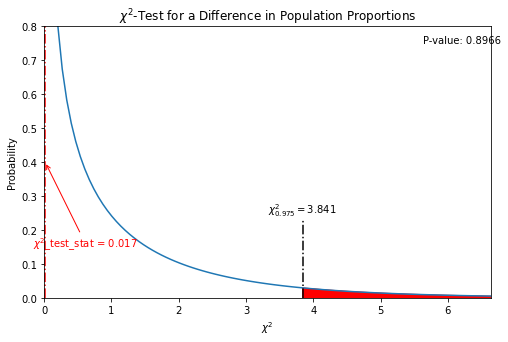

In [1315]:
end_point = 20

x_min = chi2.ppf(0.01, df)
x_max = chi2.ppf(0.99, df)
x = np.linspace(x_min, x_max, 100)
x_rejection_right = np.linspace(chi_square_crit, end_point, 100)

Y_right = chi2.pdf(x_rejection_right, df)
Y_test_stat = chi2.pdf(chi_square_test_stat, df)

plt.plot(x, chi2.pdf(x, df))
plt.vlines(x=chi_square_test_stat, ymin=0, ymax=Y_test_stat+10, color='red', linestyle='-.')
plt.vlines(x=chi_square_crit, ymin=0, ymax=Y_right.max()+0.2, color='black', linestyle='-.')
plt.fill_between(x_rejection_right, Y_right, 0, color='red')

text = fr'$\chi^2$_test_stat = {chi_square_test_stat:.3f}'

plt.annotate(text, 
             xy=(chi_square_test_stat, st.norm.pdf(chi_square_test_stat)),
             xytext=(chi_square_test_stat+0.6, st.norm.pdf(chi_square_test_stat)-0.25),
             ha='center',
             color='red',
             arrowprops= {'arrowstyle':'->', 
                 'connectionstyle':'arc3', 'color':'red'})

x_rejection_right_rounded = np.round(chi_square_crit, 3)
text = fr'$\chi^2_{{{1-alpha/2}}}= {x_rejection_right_rounded}$'

plt.annotate(text, 
             xy=(chi_square_crit, chi2.pdf(chi_square_crit, df)+0.22), 
             ha='center')

plt.annotate(f'P-value: {p_val:.4f}', xy=(x_max-1, 0.75), ha='left')

plt.xlim(0, x_max)
plt.ylim(0, 0.8)
plt.xlabel(r'$\chi^2$')
plt.ylabel('Probability')
plt.title(r'$\chi^2$-Test for a Difference in Population Proportions')

fig = plt.gcf()
fig.set_size_inches(8,5)

plt.savefig('/users/rancher/Google Drive/Coding/website/github_pages/images/acupuncture_analysis/chi_square_graph1.png')

#### *Step 4: Conclusion - Same as in Q1.b, but using Chi-Square Distribution*

Fail to reject $H_0$ because the calculated test statistic is not in the rejection region.  We don't have statistically significant evidence that there is a difference in the proportion of high 24-hour SBP values (130+ mmHg) at 24 weeks between individuals less than 60 years and greater than or equal to 60 years, at $\alpha=0.05$.

### Q1.c: Constructing a confidence interval for the true difference in proportions of high 24-hour SBP values (130+ mmHg) at 24 weeks between individuals less than 60 years and greater than or equal to 60 years.

Calculate the confidence interval based off of the following formula:

$(\hat{p}_1 - \hat{p}_2) \pm z_{\alpha/2}\sqrt{\frac{\hat{p}_1*\hat{q}_1}{n_1} + \frac{\hat{p}_2*\hat{q}_2}{n_2}}$

where $\hat{q}_1 = 1 - \hat{p}_1 \text{ and } \hat{q}_2 = 1 - \hat{p}_2$

In [1316]:
conf_level = 0.95
alpha = 1 - conf_level

phat1 = x_counts[0] / n_counts[0]
phat2 = x_counts[1] / n_counts[1]
qhat1 = 1 - phat1
qhat2 = 1 - phat2

z_crit = norm.ppf(1 - alpha / 2)
std_error = np.sqrt((phat1*(qhat1)/n_counts[0]) + (phat2*(qhat2)/n_counts[1]))

lower_bound = (phat1 - phat2) - z_crit * std_error
upper_bound = (phat1 + phat2) - z_crit * std_error

print(F"With {conf_level*100:.0f}% confidence, the true difference in proportions of high 24-hour SBP values (130+ mmHg) at 24 weeks between individuals less than 60 years and greater than or equal to 60 years is between {lower_bound:.4f} and {upper_bound:.4f}")

With 95% confidence, the true difference in proportions of high 24-hour SBP values (130+ mmHg) at 24 weeks between individuals less than 60 years and greater than or equal to 60 years is between -0.2589 and 0.7108


#### Confidence interal interpretation in plain English:

Because we only have sample data, sample size of 65, we are working with incomplete information and we can't make completely accurate predictions.  Nonetheless, we still want to try and predict the difference in proportions of those with high SBP among our two age groups, which is why we use an interval for our estimate, as opposed to a single value.  Our interval indicates that the difference in proportions should be somewhere between -0.2589 (-25.89%) and 0.7108 (71.08%), which is rather wide and perhaps not incredibly helpful.  Collecting more data, by repeating the experiment with a larger sample size, would be recommended before any actionable conclusions can be made. 

### Q2: Is there a significant difference in the proportion with high SBP across the four treatment groups?

Because we're looking to determine if the proportions of all four groups are the same, we can perform a Chi-Square test for homogenity.

In [1317]:
orig_df['group'].unique()

array([4, 3, 2, 1])

In [1318]:
orig_df['group'].value_counts()

4    30
3    30
2    30
1    30
Name: group, dtype: int64

#### *Step 1: Hypotheses*

$H_0:$ The proportion with high SBP (130+ mmHg) across all four treatment groups is the same

$H_a:$ At least one of the groups has a proportion with high SBP (130+ mmHg) that is different than the other groups.

In [1319]:
# Create cross tab of our observed frequencies
observed_freq_by_group = pd.crosstab(orig_df['group'], orig_df['binned_24hsbp6'])
observed_freq_by_group

binned_24hsbp6,below_130,130_or_above
group,,
1,9,4
2,11,5
3,9,7
4,5,15


#### *Step 2: Critical value(s)*

Reject the null hypothesis ($H_0$) if the calculated test statistic is greater than or equal to 7.815, based on a right tailed test using the Chi-Square ($\chi^2$) Distribution with $\alpha = 0.05$

$\chi^2_{\alpha, df} \geq 7.815$

where $df = (r - 1) * (c - 1)$

In [1320]:
num_rows = observed_freq_by_group.shape[0]
num_cols = observed_freq_by_group.shape[1]

alpha = 0.05
df = (num_rows - 1) * (num_cols - 1)

chi_square_crit = chi2.ppf(1-alpha, df = df)
print(F"Chi-Square Critical Value: {chi_square_crit:.3f}")

Chi-Square Critical Value: 7.815


In [1321]:
# Use statsmodels to compute the test stat, p-value, and expected frequencies
results = st.chi2_contingency(observed_freq_by_group)
expected_freq_by_group = pd.DataFrame(st.chi2_contingency(observed_freq_by_group)[3], index = [1, 2, 3, 4], columns = [n24hsbp6_labels])
expected_freq_by_group

,below_130,130_or_above
1,6.800000,6.200000
2,8.369231,7.630769
3,8.369231,7.630769
4,10.461538,9.538462


#### *Step 3: Test Statistic*

Calculate test statistic using statsmodels library based on the following formula:
    
$\sum\limits_{i=1}^k \frac{(O_i - E_i)^2}{E_i}$

where $k = 8 \text{ based on a 4x2 table}$

In [1322]:
chi_square_test_stat, p_val = results[0:2]
true_or_false = chi_square_test_stat >= chi_square_crit

print(F'Chi-Square test stat: {chi_square_test_stat:.3f}')
print(F'P-value: {p_val:.4f}')
print(F'Test statistic in rejection region?: {true_or_false}')

Chi-Square test stat: 9.304
P-value: 0.0255
Test statistic in rejection region?: True


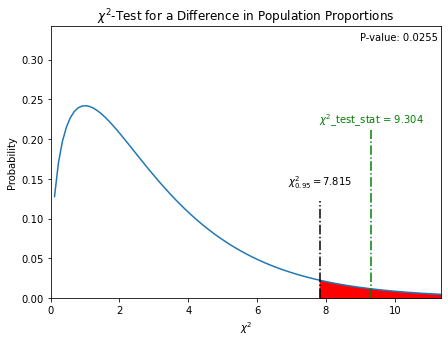

In [1323]:
x_min = chi2.ppf(0.01, df)
x_max = chi2.ppf(0.99, df)
x = np.linspace(x_min, x_max, 100)
x_rejection_right = np.linspace(chi_square_crit, end_point, 100)

Y_right = chi2.pdf(x_rejection_right, df)
Y_test_stat = chi2.pdf(chi_square_test_stat, df)

plt.plot(x, chi2.pdf(x, df))
plt.vlines(x=chi_square_test_stat, ymin=0, ymax=Y_test_stat+.2, color='green', linestyle='-.')
plt.vlines(x=chi_square_crit, ymin=0, ymax=Y_right.max()+0.1, color='black', linestyle='-.')
plt.fill_between(x_rejection_right, Y_right, 0, color='red')

text = fr'$\chi^2$_test_stat = {chi_square_test_stat:.3f}'

plt.annotate(text, 
             xy=(chi_square_test_stat, st.norm.pdf(chi_square_test_stat)+0.22),
             ha='center',
             color='green'
            )

x_rejection_right_rounded = np.round(chi_square_crit, 3)
text = fr'$\chi^2_{{{1-alpha}}}= {x_rejection_right_rounded}$'

plt.annotate(text, 
             xy=(chi_square_crit, chi2.pdf(chi_square_crit, df)+0.12), 
             ha='center')

plt.annotate(f'P-value: {p_val:.4f}', xy=(x_max-2.35, 0.325), ha='left')

plt.xlim(0, x_max)
plt.ylim(0, chi2.pdf(x,df).max()+0.1)
plt.xlabel(r'$\chi^2$')
plt.ylabel('Probability')
plt.title(r'$\chi^2$-Test for a Difference in Population Proportions')

fig = plt.gcf()
fig.set_size_inches(7,5)

plt.savefig('/users/rancher/Google Drive/Coding/website/github_pages/images/acupuncture_analysis/chi_square_graph2.png')

#### *Step 4: Conclusion - Using statistical language*

Reject $H_0$ because the calculated test statistic is in the rejection region.  We have statistically significant evidence that at least one of the treatment groups has a different proportion of high SBP (130+ mmHg) at 24 weeks, at $\alpha=0.05$.

#### Conclusion - Using plain English

At least one of the four treatment groups has a higher proportion of subjects with high SBP as compared to the rest.  This could indicate that the treatment applied to those groups was ineffective at treating systolic hypertension.  More investigation would need to be performed to determine which treatment(s) were ineffective.

### Q3: Linear regression model using age (yrs) as the independent variable (X) and 24-hour diastolic blood pressure (DBP mmHg) at 24-weeks of treatment as the dependent variable (Y)

### Q3.a: Constructing the model

In [1324]:
age_and_24hdbp = orig_df.loc[:, ['age', 'n24hdbp6']]

print(age_and_24hdbp['age'].isnull().value_counts())
print()
print(age_and_24hdbp['n24hdbp6'].isnull().value_counts())

False    119
True       1
Name: age, dtype: int64

False    65
True     55
Name: n24hdbp6, dtype: int64


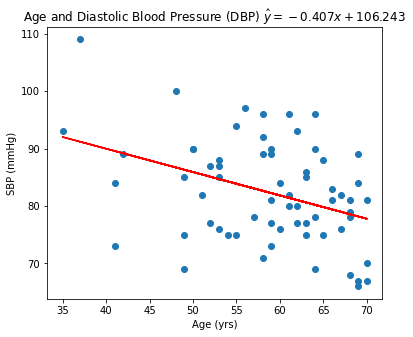

In [1325]:
# Because there is one null value for age and 55 null values for n24hdbp6, we drop any rows containing null values, then perform the regression.

non_null_age_and_24hdbp = age_and_24hdbp.loc[age_and_24hdbp.isnull().any(axis=1)==False]

lm_dbp_age = ols(formula = 'n24hdbp6 ~ age', data=non_null_age_and_24hdbp).fit()

intercept = lm_dbp_age.params[0]
slope = lm_dbp_age.params[1]

# Graphing scatter plot to visualize data and see the fit of our regression equation
x = (non_null_age_and_24hdbp['age'])

fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.scatter(non_null_age_and_24hdbp['age'], non_null_age_and_24hdbp['n24hdbp6'])
ax.set_title(rf'Age and Diastolic Blood Pressure (DBP) $\hat{{y}} = %.3fx + %.3f$'%(slope, intercept))
ax.set_xlabel('Age (yrs)')
ax.set_ylabel('SBP (mmHg)')
ax.plot(x, slope*x+intercept, color='r');
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/acupuncture_analysis/lin_reg_age_dbp.png", bbox_inches="tight")

#md('Linear Regression equation: $\hat{y} = %.3fx + %.3f$'%(slope, intercept))

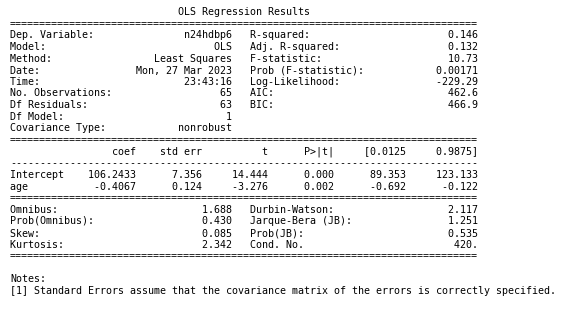

In [1326]:
alpha = 0.025
plt.rc('figure', figsize=(5, 5))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(lm_dbp_age.summary(alpha=alpha)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
#plt.tight_layout()
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/acupuncture_analysis/lin_reg_q3_summary.png", bbox_inches="tight")

### Q3.b: Checking for significance in the slope of the linear model using ANOVA and the F-Distribution

#### *Step 1: Hypotheses*

<ins>In words</ins><br>
$H_0:$ There is no linear relationship between age and 24hr DBP. <br>
$H_a:$ There is a linear relationship between age and 24hr DBP.

<ins>Using Symbols</ins><br>
$H_0: \beta_1 = 0$<br>
$H_a: \beta_1 \neq 0$

#### *Step 2: Critical value(s)*

Reject the null hypothesis ($H_0$) if the calculated test statistic is greater than or equal to 5.27, based on a right tailed test using the F Distribution with $\alpha = 0.025$

$F_{1-\alpha, \text{df_num, df_denom}} \geq 5.27$

where $df_\text{num} = 1 \text{ and } df_\text{denom} = n - 2$

In [1327]:
alpha = 0.025
df_num = 1
df_denom = non_null_age_and_24hdbp.shape[0] - 2

F_crit = f.ppf(1-alpha, df_num, df_denom)
print(F"F critical value: {F_crit:.2f}")

F critical value: 5.27


#### *Step 3: Test Statistic*

Calculate test statistic using statsmodels library based on the following formula:
    
$F = \frac{\text{MSR}}{\text{MSE}}$

where $\text{MSR} = \text{SSR} \text{ and } \text{MSE} = \frac{\text{SSE}}{n-2}$

In [1328]:
results = sm.stats.anova_lm(lm_dbp_age, typ=2)
results

,sum_sq,df,F,PR(>F)
age,751.427167,1.0,10.734777,0.001712
Residual,4409.957449,63.0,NaN,NaN


In [1329]:
F_test_stat = results.loc['age', 'F']
p_val = results.loc['age', 'PR(>F)']
true_or_false = F_test_stat >= F_crit

print(F'F test stat: {F_test_stat:.2f}')
print(F'P-value: {p_val:.4f}')
print(F'Test statistic in rejection region?: {true_or_false}')

F test stat: 10.73
P-value: 0.0017
Test statistic in rejection region?: True


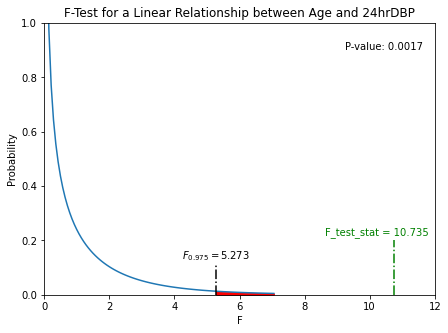

In [1330]:
x_min = f.ppf(0.01, df_num, df_denom)
x_max = f.ppf(0.99, df_num, df_denom)
x = np.linspace(x_min, x_max, 100)
x_rejection_right = np.linspace(F_crit, x_max, 100)

Y_right = f.pdf(x_rejection_right, df_num, df_denom)
Y_test_stat = f.pdf(F_test_stat, df_num, df_denom)

plt.plot(x, f.pdf(x, df_num, df_denom))
plt.vlines(x=F_test_stat, ymin=0, ymax=Y_test_stat+.2, color='green', linestyle='-.')
plt.vlines(x=F_crit, ymin=0, ymax=Y_right.max()+0.1, color='black', linestyle='-.')
plt.fill_between(x_rejection_right, Y_right, 0, color='red')

text = f'F_test_stat = {F_test_stat:.3f}'

plt.annotate(text, 
             xy=(F_test_stat-0.5, f.pdf(F_test_stat, df_num, df_denom)+0.22),
             ha='center',
             color='green'
            )

x_rejection_right_rounded = np.round(F_crit, 3)
text = fr'$F_{{{1-alpha}}}= {x_rejection_right_rounded}$'

plt.annotate(text, 
             xy=(F_crit, f.pdf(F_crit, df_num, df_denom)+0.12), 
             ha='center')

plt.annotate(f'P-value: {p_val:.4f}', xy=(9.25, 0.9), ha='left')

plt.xlim(0, 12)
plt.ylim(0, 1)
plt.xlabel('F')
plt.ylabel('Probability')
plt.title('F-Test for a Linear Relationship between Age and 24hrDBP')

fig = plt.gcf()
fig.set_size_inches(7,5)

plt.savefig('/users/rancher/Google Drive/Coding/website/github_pages/images/acupuncture_analysis/f_dist_graph1.png')

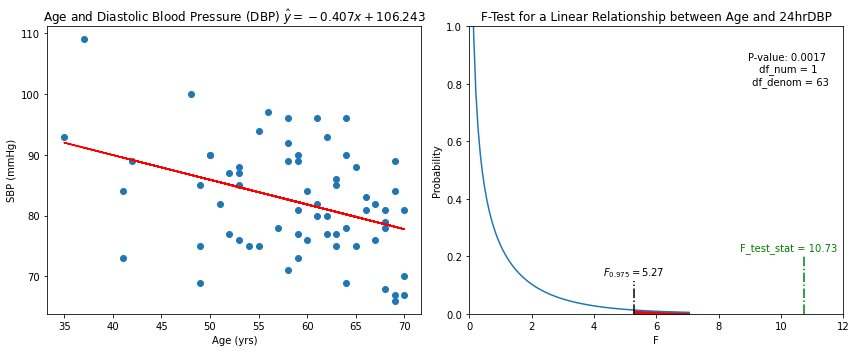

In [1331]:
# Because there is one null value for age and 55 null values for n24hdbp6, we drop any rows containing null values, then perform the regression.

non_null_age_and_24hdbp = age_and_24hdbp.loc[age_and_24hdbp.isnull().any(axis=1)==False]

lm_dbp_age = ols(formula = 'n24hdbp6 ~ age', data=non_null_age_and_24hdbp).fit()

intercept = lm_dbp_age.params[0]
slope = lm_dbp_age.params[1]

x = (non_null_age_and_24hdbp['age'])

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(non_null_age_and_24hdbp['age'], non_null_age_and_24hdbp['n24hdbp6'])
ax[0].set_title(rf'Age and Diastolic Blood Pressure (DBP) $\hat{{y}} = %.3fx + %.3f$'%(slope, intercept))
ax[0].set_xlabel('Age (yrs)')
ax[0].set_ylabel('SBP (mmHg)')
ax[0].plot(x, slope*x+intercept, color='r')


x_min = f.ppf(0.01, df_num, df_denom)
x_max = f.ppf(0.99, df_num, df_denom)
x = np.linspace(x_min, x_max, 100)
x_rejection_right = np.linspace(F_crit, x_max, 100)

Y_right = f.pdf(x_rejection_right, df_num, df_denom)
Y_test_stat = f.pdf(F_test_stat, df_num, df_denom)

ax[1].plot(x, f.pdf(x, df_num, df_denom))
ax[1].vlines(x=F_test_stat, ymin=0, ymax=Y_test_stat+.2, color='green', linestyle='-.')
ax[1].vlines(x=F_crit, ymin=0, ymax=Y_right.max()+0.1, color='black', linestyle='-.')
ax[1].fill_between(x_rejection_right, Y_right, 0, color='red')

text = f'F_test_stat = {F_test_stat:.2f}'

ax[1].annotate(text, 
             xy=(F_test_stat-0.5, f.pdf(F_test_stat, df_num, df_denom)+0.22),
             ha='center',
             color='green'
            )

x_rejection_right_rounded = np.round(F_crit, 2)
text = fr'$F_{{{1-alpha}}}= {x_rejection_right_rounded}$'

ax[1].annotate(text, 
             xy=(F_crit, f.pdf(F_crit, df_num, df_denom)+0.12), 
             ha='center')

ax[1].annotate(f'P-value: {p_val:.4f} \n df_num = {df_num} \n df_denom = {df_denom}', xy=(10.25, 0.8), ha='center')

ax[1].set_xlim(0, 12)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('F')
ax[1].set_ylabel('Probability')
ax[1].set_title('F-Test for a Linear Relationship between Age and 24hrDBP')

plt.tight_layout()


plt.savefig('/users/rancher/Google Drive/Coding/website/github_pages/images/acupuncture_analysis/q3_graph1.png')

#### *Step 4: Conclusion - Using statistical language*

Reject $H_0$ because the calculated test statistic is in the rejection region.  We have statistically significant evidence that there is a linear relationship between age (yrs) and 24-hour diastolic blood pressure (mmHg) at 24-weeks of treatment, at $\alpha=0.05$.

#### Conclusion - Using plain English:

It would appear that age (yrs) can be a useful way to predict a patient's diastolic blood pressure (DBP in mmHg).  There may be better ways to predict a patients DBP than using age and our predictions might be improved if we included other types of information as well, such as gender, race, etc.

### Q3.c: Confidence interval for the slope

Calculate the confidence interval using the statsmodels library.

In [1332]:
conf_level = 0.90
alpha = 1 - conf_level

lower_bound, upper_bound = lm_dbp_age.conf_int(alpha=alpha).loc['age', [0,1]]

print(F"We are {conf_level*100:.0f}% confident that the true population slope is between {lower_bound:.4f} and {upper_bound:.4f} mmHg/year")

We are 90% confident that the true population slope is between -0.6140 and -0.1995 mmHg/year


#### Confidence interal interpretation in plain English:

Because we only have sample data, sample size of 65, we are working with incomplete information and we can't make completely accurate predictions.  Nonetheless, we still want to try and predict how an increase in one's age will affect one's diastolic blood pressure (DBP in mmHg).  To do so, we use an interval estimate, as opposed to a single value estimate, in order to be more confident that our estimate will be correct.  

This confidence interval estimates that for each additional year older a patient gets, their DBP will change by anywhere between -0.6140 and -0.1995 mmHg.  Because our interval contains only negative values, it implies that one's DBP has a tendency to decrease with age. 

### Q3.d: Confidence interval for the intercept

Calculate the confidence interval using the statsmodels library.

In [1333]:
lower_bound, upper_bound = lm_dbp_age.conf_int(alpha=alpha).loc['Intercept', [0,1]]

print(F"We are {conf_level*100:.0f}% confident that the true population intercept is between {lower_bound:.4f} and {upper_bound:.4f} mmHg")

We are 90% confident that the true population intercept is between 93.9639 and 118.5227 mmHg


#### Confidence interal interpretation in plain English:

Given that our linear regression equation is as follows: $\hat{y}=-0.407x + 106.243$, where x is a patient's age in years and $\hat{y}$ is the patient's predicted diastolic blood pressure (DBP) in mmHg, the y-intercept of 106.243 would indicate a patient's predicted DBP for an age of 0 years (x=0).  With this in mind, the intercept doesn't really make sense, and interpreting the confidence interval isn't super useful.

### Q4: Linear regression model using age (yrs) as the independent variable (X) and 24-hour *Systolic* blood pressure (SBP mmHg) at 24-weeks of treatment as the dependent variable (Y)

### Q4.a: Constructing the model

In [1334]:
age_and_24hsbp = orig_df.loc[:, ['age', 'n24hsbp6']]

print(age_and_24hsbp['age'].isnull().value_counts())
print()
print(age_and_24hsbp['n24hsbp6'].isnull().value_counts())

False    119
True       1
Name: age, dtype: int64

False    65
True     55
Name: n24hsbp6, dtype: int64


Linear Regression equation: $\hat{y} = -0.162x + 138.582$

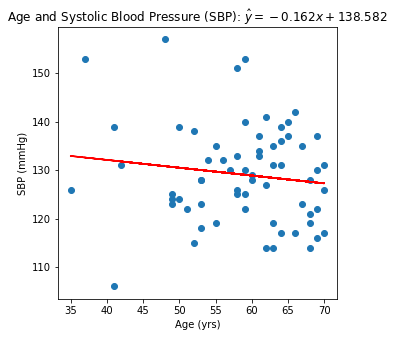

In [1335]:
# Because there is one null value for age and 55 null values for n24hsbp6, we drop any rows containing null values, then perform the regression.

non_null_age_and_24hsbp = age_and_24hsbp.loc[age_and_24hsbp.isnull().any(axis=1)==False]

lm_sbp_age = ols(formula = 'n24hsbp6 ~ age', data=non_null_age_and_24hsbp).fit()

intercept = lm_sbp_age.params[0]
slope = lm_sbp_age.params[1]

# Graphing scatter plot to visualize data and see the fit of our regression equation
x = non_null_age_and_24hsbp['age']

plt.scatter(non_null_age_and_24hsbp['age'], non_null_age_and_24hsbp['n24hsbp6'])
plt.title('Age and Systolic Blood Pressure (SBP): $\hat{{y}} = %.3fx + %.3f$'%(slope, intercept))
plt.xlabel('Age (yrs)')
plt.ylabel('SBP (mmHg)')
plt.plot(x, slope*x+intercept, color='r');

md('Linear Regression equation: $\hat{y} = %.3fx + %.3f$'%(slope, intercept))

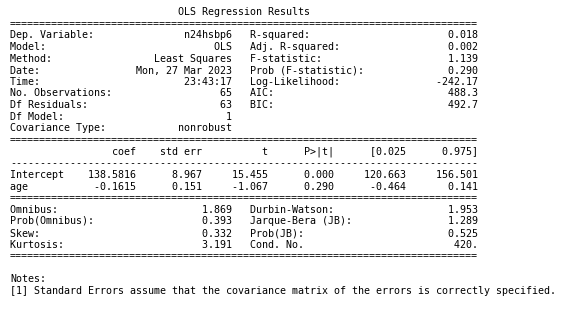

In [1336]:
alpha = 0.05
plt.rc('figure', figsize=(5, 5))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(lm_sbp_age.summary(alpha=alpha)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
#plt.tight_layout()
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/acupuncture_analysis/lin_reg_q3_summary.png", bbox_inches="tight")

In [1337]:
alpha = 0.05
lm_sbp_age.summary(alpha=alpha)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               n24hsbp6   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.139
Date:                Mon, 27 Mar 2023   Prob (F-statistic):              0.290
Time:                        23:43:18   Log-Likelihood:                -242.17
No. Observations:                  65   AIC:                             488.3
Df Residuals:                      63   BIC:                             492.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    138.5816      8.967     15.455      0.000     120.663     156.501
age           -0.1615      0.151     -1.067      0.290      -0.464       0.141
==============================================================================
Omnibus:                        1.869   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.393   Jarque-Bera (JB):                1.289
Skew:                           0.332   Prob(JB):                        0.525
Kurtosis:                       3.191   Cond. No.                         420.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q4.b: Checking for significance in the slope of the linear model using ANOVA and the F-Distribution

#### *Step 1: Hypotheses*

<ins>In words</ins><br>
$H_0:$ There is no linear relationship between age and 24hr SBP. <br>
$H_a:$ There is a linear relationship between age and 24hr SBP.

<ins>Using Symbols</ins><br>
$H_0: \beta_1 = 0$<br>
$H_a: \beta_1 \neq 0$

#### *Step 2: Critical value(s)*

Reject the null hypothesis ($H_0$) if the calculated test statistic is greater than or equal to 3.99, based on a right tailed test using the F Distribution with $\alpha = 0.05$

$F_{1-\alpha, \text{df_num, df_denom}} \geq 3.99$

where $df_\text{num} = 1 \text{ and } df_\text{denom} = n - 2$

In [1338]:
alpha = 0.05
df_num = 1
df_denom = non_null_age_and_24hsbp.shape[0] - 2

F_crit = f.ppf(1-alpha, df_num, df_denom)
print(F"F critical value: {F_crit:.2f}")

F critical value: 3.99


#### *Step 3: Test Statistic*

Calculate test statistic using statsmodels library based on the following formula:
    
$F = \frac{\text{MSR}}{\text{MSE}}$

where $\text{MSR} = \text{SSR} = \sum\limits_{i=i}^n(\hat{y}_i-\bar{y}_i)^2 \text{ and } \text{MSE} = \frac{\text{SSE}}{n-2}=\frac{\sum\limits_{i=1}^n(y_i-\hat{y}_i)^2}{n-2}$

In [1339]:
results = sm.stats.anova_lm(lm_sbp_age, typ=2)
results

,sum_sq,df,F,PR(>F)
age,118.482713,1.0,1.13895,0.289947
Residual,6553.763440,63.0,NaN,NaN


In [1340]:
F_test_stat = results.loc['age', 'F']
p_val = results.loc['age', 'PR(>F)']
true_or_false = F_test_stat >= F_crit

print(F'F test stat: {F_test_stat:.2f}')
print(F'P-value: {p_val:.4f}')
print(F'Test statistic in rejection region?: {true_or_false}')

F test stat: 1.14
P-value: 0.2899
Test statistic in rejection region?: False


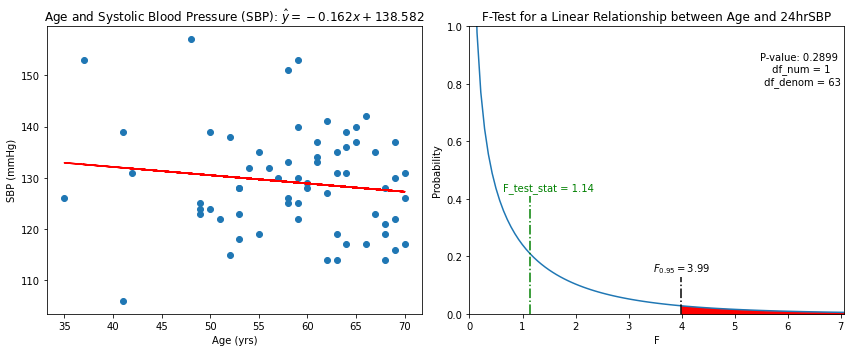

In [1341]:
# Because there is one null value for age and 55 null values for n24hsbp6, we drop any rows containing null values, then perform the regression.

non_null_age_and_24hsbp = age_and_24hsbp.loc[age_and_24hsbp.isnull().any(axis=1)==False]

lm_sbp_age = ols(formula = 'n24hsbp6 ~ age', data=non_null_age_and_24hsbp).fit()

intercept = lm_sbp_age.params[0]
slope = lm_sbp_age.params[1]

# Graphing scatter plot to visualize data and see the fit of our regression equation
x = non_null_age_and_24hsbp['age']

fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].scatter(non_null_age_and_24hsbp['age'], non_null_age_and_24hsbp['n24hsbp6'])
ax[0].set_title('Age and Systolic Blood Pressure (SBP): $\hat{{y}} = %.3fx + %.3f$'%(slope, intercept))
ax[0].set_xlabel('Age (yrs)')
ax[0].set_ylabel('SBP (mmHg)')
ax[0].plot(x, slope*x+intercept, color='r');


x_min = f.ppf(0.01, df_num, df_denom)
x_max = f.ppf(0.99, df_num, df_denom)
x = np.linspace(x_min, x_max, 100)
x_rejection_right = np.linspace(F_crit, x_max, 100)

Y_right = f.pdf(x_rejection_right, df_num, df_denom)
Y_test_stat = f.pdf(F_test_stat, df_num, df_denom)

ax[1].plot(x, f.pdf(x, df_num, df_denom))
ax[1].vlines(x=F_test_stat, ymin=0, ymax=Y_test_stat+.2, color='green', linestyle='-.')
ax[1].vlines(x=F_crit, ymin=0, ymax=Y_right.max()+0.1, color='black', linestyle='-.')
ax[1].fill_between(x_rejection_right, Y_right, 0, color='red')

text = f'F_test_stat = {F_test_stat:.2f}'

ax[1].annotate(text, 
             xy=(F_test_stat-0.5, f.pdf(F_test_stat, df_num, df_denom)+0.22),
             ha='left',
             color='green'
            )

x_rejection_right_rounded = np.round(F_crit, 2)
text = fr'$F_{{{1-alpha}}}= {x_rejection_right_rounded}$'

ax[1].annotate(text, 
             xy=(F_crit, f.pdf(F_crit, df_num, df_denom)+0.12), 
             ha='center')

ax[1].annotate(f'P-value: {p_val:.4f} \n df_num = {df_num} \n df_denom = {df_denom}', xy=(6.25, 0.8), ha='center')

ax[1].set_xlim(0, x_max)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('F')
ax[1].set_ylabel('Probability')
ax[1].set_title('F-Test for a Linear Relationship between Age and 24hrSBP')

plt.tight_layout()

plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/acupuncture_analysis/q4_graph1.png", bbox_inches="tight")

#### *Step 4: Conclusion - Using statistical language*

Fail to reject $H_0$ because the calculated test statistic is not in the rejection region.  We do not have statistically significant evidence that there is a linear relationship between age (yrs) and 24-hour systolic blood pressure (mmHg) at 24-weeks of treatment, at $\alpha=0.05$.

#### Conclusion - Using plain English

Essentially, we don't have enough information to conclude that a patient's age in years plays a contributing role in predicting the patient's systolic blood pressure (SBP) in mmHg.  We should either collect more data and run the hypothesis test again, or we should look to other types of information to make this kind of prediction.

### Q4.c: Alternatively, we could use the t-Distribution to test the same hypothesis as in Q4.b, which is as follows:

#### *Step 1: Hypotheses*

<ins>In words</ins><br>
$H_0:$ There is no linear relationship between age and 24hr SBP. <br>
$H_a:$ There is a linear relationship between age and 24hr SBP.

<ins>Using Symbols</ins><br>
$H_0: \beta_1 = 0$<br>
$H_a: \beta_1 \neq 0$

#### *Step 2: Critical value(s)*

Reject the null hypothesis ($H_0$) if the calculated test statistic is less than or equal to -1.998, or greater than or equal to 1.998, based on a two-tailed test using the t-Distribution with $\alpha = 0.05$

$t_{\alpha/2, \text{df}} \leq -1.998 \text{ or } t_{1-\alpha/2, \text{df}} \geq 1.998$

where $df = n - 1$

In [1342]:
alpha = 0.05
df = non_null_age_and_24hsbp.shape[0] - 1

t_crit_left = t.ppf(alpha/2, df=df)
t_crit_right = t.ppf(1-alpha/2, df=df)
print(F"t_crit_left: {t_crit_left:.3f}")
print(F"t_crit_right: {t_crit_right:.3f}")

t_crit_left: -1.998
t_crit_right: 1.998


#### *Step 3: Test Statistic*

Calculate test statistic using statsmodels library based on the following formula:
    
$t = \frac{\hat{\beta}_1}{\sqrt{\frac{\text{MSE}}{SS_{xx}}}}$

where $\text{MSE} = \frac{\text{SSE}}{n-2} = \frac{\sum\limits_{i=i}^n(y_i-\hat{y}_i)^2}{n-2} \text{ and } SS_{xx} = \sum\limits_{i=1}^n(x_i - \bar{x})^2$

In [1343]:
df_residual = non_null_age_and_24hsbp.shape[0] - 2

sse = results.loc['Residual', 'sum_sq']
mse = sse/df_residual

mean_age = non_null_age_and_24hsbp['age'].mean()
ss_xx = sum((non_null_age_and_24hsbp['age'] - mean_age)**2)

t_test_stat=slope/np.sqrt(mse/ss_xx)
p_val = 2*(1-t.cdf(abs(t_test_stat), df=df_residual))
true_or_false = abs(t_test_stat) >= t_crit_right

print(F"t_test_statistic: {t_test_stat:.3f}")
print(F"P-value: {p_val:.4f}")
print(F"Test statistic in rejection region?: {true_or_false}")

t_test_statistic: -1.067
P-value: 0.2899
Test statistic in rejection region?: False


In [1344]:
Y_left

array([0.00443185, 0.0045735 , 0.00471915, 0.0048689 , 0.00502286,
       0.00518111, 0.00534375, 0.00551089, 0.00568264, 0.00585908,
       0.00604034, 0.00622653, 0.00641774, 0.00661409, 0.0068157 ,
       0.00702268, 0.00723514, 0.00745321, 0.00767701, 0.00790665,
       0.00814227, 0.00838398, 0.00863191, 0.0088862 , 0.00914696,
       0.00941434, 0.00968847, 0.00996947, 0.0102575 , 0.01055268,
       0.01085516, 0.01116507, 0.01148257, 0.01180779, 0.01214089,
       0.012482  , 0.01283128, 0.01318888, 0.01355494, 0.01392964,
       0.0143131 , 0.01470551, 0.015107  , 0.01551774, 0.01593789,
       0.01636761, 0.01680706, 0.01725641, 0.01771581, 0.01818543,
       0.01866545, 0.01915602, 0.01965732, 0.0201695 , 0.02069275,
       0.02122723, 0.02177312, 0.02233057, 0.02289977, 0.02348089,
       0.0240741 , 0.02467957, 0.02529748, 0.02592799, 0.02657129,
       0.02722755, 0.02789693, 0.02857961, 0.02927577, 0.02998558,
       0.03070921, 0.03144683, 0.03219862, 0.03296473, 0.03374

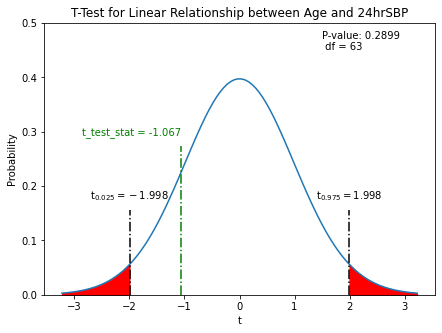

In [1345]:
x_min = t.ppf(0.001, df_residual)
x_max = t.ppf(0.999, df_residual)

x = np.linspace(x_min, x_max, 100)
x_rejection_left = np.linspace(x_min, t_crit_left, 100)
x_rejection_right = np.linspace(t_crit_right, x_max, 100)
Y_left = t.pdf(x_rejection_left, df_residual)
Y_right = t.pdf(x_rejection_right, df_residual)


plt.plot(x, t.pdf(x, df_residual))
plt.vlines(x=t_test_stat, ymin=0, ymax=t.pdf(t_test_stat, df_residual)+.05, color='green', linestyle='-.')
plt.vlines(x=t_crit_left, ymin=0, ymax=Y_left.max()+.1, color='black', linestyle='-.')
plt.vlines(x=t_crit_right, ymin=0, ymax=Y_right.max()+.1, color='black', linestyle='-.')
plt.fill_between(x_rejection_left, Y_left, 0, color='red')
plt.fill_between(x_rejection_right, Y_right, 0, color='red')

text = f't_test_stat = {t_test_stat:.3f}'

plt.annotate(text, 
             xy=(t_test_stat, t.pdf(t_test_stat, df_residual)+0.07), 
             ha='right',
             color='green')


t_crit_left_rounded = np.round(t_crit_left, 3)
text = f't$_{{{alpha/2}}}= {t_crit_left_rounded}$'

plt.annotate(text, 
             xy=(t_crit_left, t.pdf(t_crit_left, df_residual)+0.12), 
             ha='center')

t_crit_right_rounded = np.round(t_crit_right, 3)
text = f't$_{{{1-alpha/2}}}= {t_crit_right_rounded}$'

plt.annotate(text, 
             xy=(t_crit_right, t.pdf(t_crit_right, df_residual)+0.12), 
             ha='center')

plt.annotate(f'P-value: {p_val:.4f} \n df = {df_residual}', xy=(1.5, 0.45), ha='left')

#plt.xlim(x_min, x_max)
plt.ylim(0, 0.5)
plt.xlabel('t')
plt.ylabel('Probability')
plt.title('T-Test for Linear Relationship between Age and 24hrSBP')

fig = plt.gcf()
fig.set_size_inches(7,5)

plt.savefig('/users/rancher/Google Drive/Coding/website/github_pages/images/acupuncture_analysis/t_dist_graph1.png')

#### *Step 4: Conclusion - same as in Q4.b, but using the t-distribution*

Fail to reject $H_0$ because the calculated test statistic is not in the rejection region.  We do not have statistically significant evidence that there is a linear relationship between age (yrs) and 24-hour systolic blood pressure (mmHg) at 24-weeks of treatment, at $\alpha=0.05$.

# Q5: Can we make our linear model better at predicting systolic blood pressure by accounting for which treatment a subject in the study received based on their treatment group, while adjusting for other factors such as age and gender?  

* Group 1: ST9-H group (120 twirls/minute at ST9 acupuncture site)
* Group 2: ST9-L group (60 twirls/minute at ST9 acupuncture site)
* Group 3: LR3-H group (120 twirls/minute at LR3 acupuncture site)
* Group 4: LR3-L group (60 twirls/minute at LR3 acupuncture site)

<img src="acupuncture_groups.png">

### Q5.a: Constructing the model

In [1346]:
group_age_gender_n24hsbp_df = orig_df.loc[:, ['group', 'age', 'gender', 'n24hsbp6']]

# Drop null values
non_null_group_age_gender_24hsbp = group_age_gender_n24hsbp_df.loc[group_age_gender_n24hsbp_df.isnull().any(axis=1)==False]

In [1347]:
# Since group assignment is a qualitative categorical variable, we have to convert it to a quantitative variable in the form of dummy variables to be able to use in our regression model
dummy_df = pd.get_dummies(non_null_group_age_gender_24hsbp, columns=['group'])

# To avoid falling in the "dummy variable trap," I drop the dummy variable for treatment group_4.  (https://www.algosome.com/articles/dummy-variable-trap-regression.html)
dummy_df.drop(labels='group_4', axis=1, inplace=True)

# Now create the multiple linear regression model and check it's performance
mult_linear_model = ols('n24hsbp6 ~ group_1 + group_2 + group_3 + age + gender', data=dummy_df).fit()

intercept = mult_linear_model.params[0]
group_1_slope = mult_linear_model.params[1]
group_2_slope = mult_linear_model.params[2]
group_3_slope = mult_linear_model.params[3]
age_slope = mult_linear_model.params[4]
gender_slope = mult_linear_model.params[5]

md('$x_1 =$ group_1 <br> $x_2 =$ group_2 <br> $x_3 =$ group_3 <br> $x_4 =$ age <br> $x_5 =$ gender <br> <br> Multiple Linear Regression equation: <br>  $\hat{y} = %.3fx_1 + %.3fx_2 + %.3fx_3 + %.3fx_4 + %.3fx_5 + %.3f$'%(group_1_slope, group_2_slope, group_3_slope, age_slope, gender_slope, intercept))

$x_1 =$ group_1 <br> $x_2 =$ group_2 <br> $x_3 =$ group_3 <br> $x_4 =$ age <br> $x_5 =$ gender <br> <br> Multiple Linear Regression equation: <br>  $\hat{y} = -5.181x_1 + -8.143x_2 + -5.424x_3 + -0.040x_4 + 3.143x_5 + 130.324$

### Q5.b: Checking for significance in the coefficients of our independent variables as a whole in our linear model using ANOVA and the F-Distribution (Omnibus test)

#### *Step 1: Hypotheses*

<ins>In words</ins><br>
$H_0:$ None of our six independent variables explain the variation in 24hr SBP. <br>
$H_a:$ At least one of our six independent variables explains the variation in 24hr SBP.

<ins>Using Symbols</ins><br>
$H_0: \beta_1 = \beta_2 = \beta_3 = \beta_4 = \beta_5 = 0$<br>
$H_a: \text{not all } \beta_i = 0$, where $k = 1, 2, 3, 4, \text{or } 5$

#### *Step 2: Critical value(s)*

Reject the null hypothesis ($H_0$) if the calculated test statistic is greater than or equal to 2.37, based on a right tailed test using the F Distribution with $\alpha = 0.05$

$F_{1-\alpha, \text{df_num, df_denom}} \geq 2.37$

where $df_\text{num} = k \text{ and } df_\text{denom} = n - k - 1 \text{, k = number of variables in model}$

In [1348]:
alpha = 0.05
df_num = dummy_df.shape[1] - 1
df_denom = dummy_df.shape[0] - df_num - 1

F_crit = f.ppf(1-alpha, df_num, df_denom)
print(F"F critical value: {F_crit:.2f}")

F critical value: 2.37


#### *Step 3: Test Statistic*

Calculate test statistic using the following formula:
    
$F = \frac{\text{MSR}}{\text{MSE}}$

where $\text{MSR} = \frac{\text{SSR}}{k} = \frac{\sum\limits_{i=i}^n(\hat{y}_i-\bar{y}_i)^2}{k} \text{ and } \text{MSE} = \frac{\text{SSE}}{n-k-1}=\frac{\sum\limits_{i=1}^n(y_i-\hat{y}_i)^2}{n-k-1}$

and $df_{denom} = n - k - 1$

In [1349]:
x = dummy_df.loc[:, ['age', 'gender', 'group_1', 'group_2', 'group_3']]
y = dummy_df.loc[:, 'n24hsbp6']
y_bar = dummy_df.loc[:, 'n24hsbp6'].mean()
k = df_num

y_hat = mult_linear_model.predict(x)

ssr = sum((y_hat - y_bar)**2)
msr = ssr/k

sse = sum((y - y_hat)**2)
mse = sse/df_denom

F_test_stat = msr/mse
p_val = 1 - f.cdf(F_test_stat, df_num, df_denom)
true_or_false = F_test_stat >= F_crit

print(F"F test statistic: {F_test_stat:.2f}")
print(F"P-value: {p_val:.4f}")
print(F"Test statistic in rejection region?: {true_or_false}")

F test statistic: 1.62
P-value: 0.1698
Test statistic in rejection region?: False


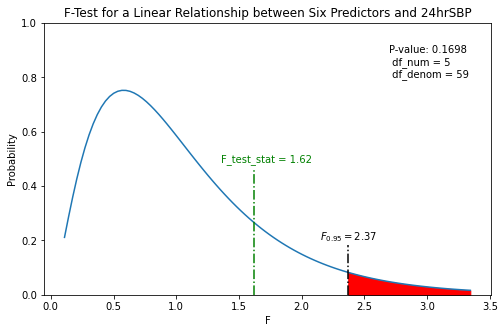

In [1350]:
x_min = f.ppf(0.01, df_num, df_denom)
x_max = f.ppf(0.99, df_num, df_denom)
x = np.linspace(x_min, x_max, 100)
x_rejection_right = np.linspace(F_crit, x_max, 100)

Y_right = f.pdf(x_rejection_right, df_num, df_denom)
Y_test_stat = f.pdf(F_test_stat, df_num, df_denom)

plt.plot(x, f.pdf(x, df_num, df_denom))
plt.vlines(x=F_test_stat, ymin=0, ymax=Y_test_stat+.2, color='green', linestyle='-.')
plt.vlines(x=F_crit, ymin=0, ymax=Y_right.max()+0.1, color='black', linestyle='-.')
plt.fill_between(x_rejection_right, Y_right, 0, color='red')

text = f'F_test_stat = {F_test_stat:.2f}'

plt.annotate(text, 
             xy=(F_test_stat+0.1, f.pdf(F_test_stat, df_num, df_denom)+0.22),
             ha='center',
             color='green'
            )

x_rejection_right_rounded = np.round(F_crit, 2)
text = fr'$F_{{{1-alpha}}}= {x_rejection_right_rounded}$'

plt.annotate(text, 
             xy=(F_crit, f.pdf(F_crit, df_num, df_denom)+0.12), 
             ha='center')

plt.annotate(f'P-value: {p_val:.4f} \n df_num = {df_num} \n df_denom = {df_denom}', xy=(2.7, 0.8), ha='left')


plt.ylim(0, 1)
plt.xlabel('F')
plt.ylabel('Probability')
plt.title('F-Test for a Linear Relationship between Six Predictors and 24hrSBP')

fig = plt.gcf()
fig.set_size_inches(8,5)

plt.savefig('/users/rancher/Google Drive/Coding/website/github_pages/images/acupuncture_analysis/f_dist_graph2.png')

#### *Step 4: Conclusion - Using statistical language*

Fail to reject $H_0$ because the calculated test statistic is not in the rejection region.  We do not have statistically significant evidence that there is a linear relationship between treatment group and 24-hour systolic blood pressure (mmHg) at 24-weeks of treatment, while adjusting for age and gender, at $\alpha=0.05$.  In other words, $\beta_1 = \beta_2 = \beta_3 = \beta_4 = \beta_5 = \beta_6 = 0$

#### Conclusion - Using plain English

Collectively, treatment group assignment, age, and gender, do not do a great job at predicting one's systolic blood pressure (SBP) in mmHg.  Perhaps a linear model is not appropriate and these variables would do a better job at predicting SBP in some other kind of model.  Alternatively, our model might make better predictions if we considered removing variables entirely, removing variables and replacing them with others, or adding additional variables to the model.

#### Q5.c: Testing for a significant treatment group effect after accounting for age and gender.

#### *Step 1: Hypotheses*

<ins>In words</ins><br>
$H_0:$ Treatment group 2 is a significant treatment group in explaining the variation in 24hr SBP. <br>
$H_a:$ Treatment group 2 is *NOT* a significant treatment group in explaining the variation in 24hr SBP.

<ins>Using Symbols</ins><br>
$H_0: \beta_2 = 0 | (x_1, x_3, x_4, x_5)$<br>
$H_a: \beta_2 \neq 0 | (x_1, x_3, x_4, x_5)$

#### *Step 2: P value*

Reject the null hypothesis ($H_0$) if the calculated P-value is less than or equal to 0.05, based on a two-tailed t test with $\alpha = 0.05$

$P \leq \alpha$

where $df = n - k - 1 \text{, k = number of variables in model}$

In [1351]:
p_val = mult_linear_model.pvalues[2]
true_or_false = p_val <= alpha

print(F"P-value: {p_val:.4f}")
print(F"P-value <= alpha?: {true_or_false}")

P-value: 0.0200
P-value <= alpha?: True


In [1352]:
mult_linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               n24hsbp6   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     1.616
Date:                Mon, 27 Mar 2023   Prob (F-statistic):              0.170
Time:                        23:43:19   Log-Likelihood:                -238.58
No. Observations:                  65   AIC:                             489.2
Df Residuals:                      59   BIC:                             502.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    130.3237     12.315     10.583      0.000     105.682     154.966
group_1       -5.1811      3.577     -1.448      0.153     -12.339       1.977
group_2       -8.1426      3.404     -2.392      0.020     -14.954      -1.331
group_3       -5.4242      3.369     -1.610      0.113     -12.165       1.317
age           -0.0401      0.161     -0.249      0.804      -0.362       0.281
gender         3.1425      3.081      1.020      0.312      -3.023       9.308
==============================================================================
Omnibus:                        1.490   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.475   Jarque-Bera (JB):                0.930
Skew:                           0.273   Prob(JB):                        0.628
Kurtosis:                       3.212   Cond. No.                         600.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

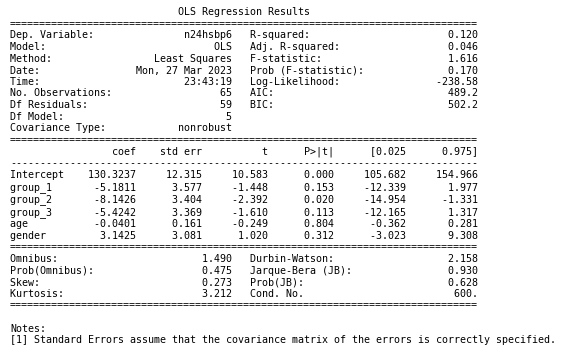

In [1353]:
plt.rc('figure', figsize=(5, 5))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(mult_linear_model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
#plt.tight_layout()
plt.savefig("/users/rancher/Google Drive/Coding/website/github_pages/images/acupuncture_analysis/mult_lin_reg_q5_summary.png", bbox_inches="tight")

#### *Step 4: Conclusion - Using statistical language*

Reject $H_0$ because the calculated P-value is less than alpha (0.05).  We have statistically significant evidence that treatmenet group 2 explains variation in 24-hour systolic blood pressure (mmHg) at 24-weeks of treatment, while adjusting for age and gender, at $\alpha=0.05$.  In other words, $\beta_2|(x_1, x_3, x_4, x_5) \neq 0$

#### Conclusion - Using plain English

While we mentioned previously that these variables didn't do a great job of predicting a patient's SBP, it appears that whether or not a patient was in treatment group 2 did have a significant impact on our predictions.  If we wish to try and construct other linear models, we should consider keeping this variable in.